In [18]:
import cobra
from cobra.io import load_model
import matplotlib.pyplot as plt

# load the textbook model
model = load_model("textbook")

In [19]:
# def perform_dfba(model, initial_conditions, kinetic_params, time_points, biomass_reaction, substrate_update_reactions, dt):
def perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, # (Km, Vmax)
    time_points, 
    biomass_reaction, 
    substrate_update_reactions, 
    dt, 
    biomass_identifier='biomass',
):

    """
    Perform dynamic FBA (dFBA) simulation.
    ...
    """
    results = {key: [value] for key, value in initial_conditions.items()}

    # Correctly initialize results dictionary for time points
    for key in results:
        for _ in range(1, len(time_points)):
            results[key].append(0)  # Pre-fill with 0 to match the length of time_points

    for t_i in range(1, len(time_points)):
        for substrate, reaction_id in substrate_update_reactions.items():
            Km, Vmax = kinetic_params[substrate]
            substrate_concentration = results[substrate][t_i-1]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate

        solution = model.optimize()
        if solution.status == 'optimal':
            biomass_growth_rate = solution.fluxes[biomass_reaction]
            
            results[biomass_identifier][t_i] = results[biomass_identifier][t_i-1] + biomass_growth_rate * results[biomass_identifier][t_i-1] * dt

            for substrate, reaction_id in substrate_update_reactions.items():
                flux = solution.fluxes[reaction_id]
                results[substrate][t_i] = max(results[substrate][t_i-1] + flux * results[biomass_identifier][t_i-1] * dt, 0)
        else:
            for key in results.keys():
                results[key][t_i] = results[key][t_i-1]

    return results



def plot_dfba_results(time_points, dfba_results, title='dFBA Simulation Results'):
    """
    Plot the results of a dFBA simulation.

    Parameters:
    - time_points (list): A list of time points at which the simulation was evaluated.
    - dfba_results (dict): A dictionary containing time series data for biomass and external metabolites.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    for key, values in dfba_results.items():
        plt.plot(time_points, values, label=key.capitalize())
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()



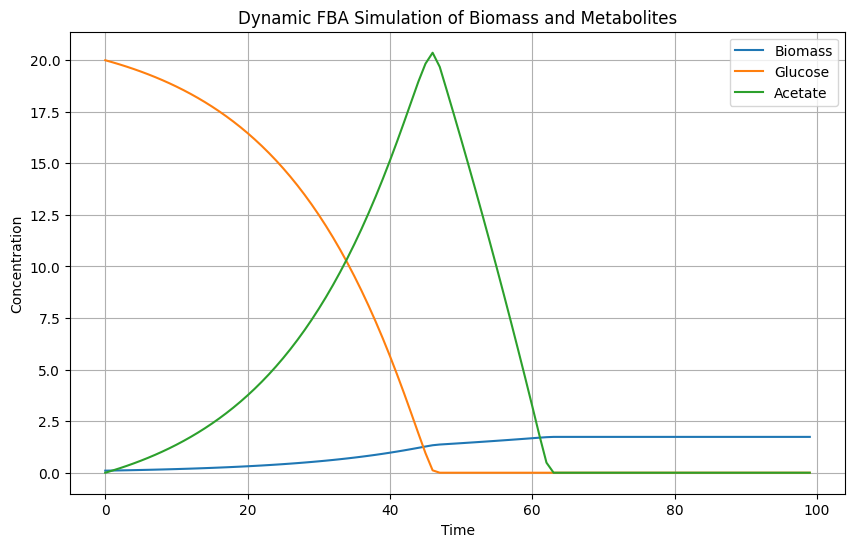

In [33]:
model.reactions.EX_o2_e.lower_bound = -2  # Limiting oxygen uptake
model.reactions.ATPM.lower_bound = 1     # Setting lower bound for ATP maintenance
model.reactions.ATPM.upper_bound = 1     # Setting upper bound for ATP maintenance

# Define initial conditions, kinetic parameters, and other necessary inputs
initial_conditions = {
    'biomass': 0.1,  # Initial biomass concentration
    'glucose': 20.0, # Initial glucose concentration
    'acetate': 0.0   # Initial acetate concentration
}
kinetic_params = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}
substrate_update_reactions = {
    'glucose': 'EX_glc__D_e',  # Exchange reaction ID for glucose
    'acetate': 'EX_ac_e'       # Exchange reaction ID for acetate
}

# simulation conditions
t_n = 100 # number of time points
dt = 0.5  # Time step, matching your setup
time_points = list(range(0, t_n))  # Simulation time points, matching your setup

# Make sure to adjust the perform_dfba function if needed to initialize result arrays with sufficient size
dfba_results = perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, 
    time_points, 
    'Biomass_Ecoli_core', 
    substrate_update_reactions, 
    dt,
    'biomass'
)

# visualize
plot_dfba_results(time_points, dfba_results, title='Dynamic FBA Simulation of Biomass and Metabolites')

## Multiple species

To simulate multiple species with dynamic FBA in a shared environment, you'll modify the environment based on the collective metabolism of all species. Each species will have its model, and their uptake rates will affect the shared external metabolite pools. Here's how you can set this up:

- **Initialization**: Create copies of the model for each species, adjusting pathways and kinetic parameters as necessary for each.
- **Shared Environment**: Manage external metabolite concentrations (like glucose and acetate) in a way that reflects their collective consumption and production by all species.
- **Simulation Loop**: For each time step, calculate the uptake and production rates for each species based on their individual models and the current state of the shared environment. Update the biomass of each species and the concentrations of shared external metabolites accordingly.

In [65]:
import copy

# Initialize models for each species
model_species_1 = model  # Assuming 'model' is your original model
model_species_2 = copy.deepcopy(model)  # Create a deep copy for the second species

# # Assuming model_species_2 is the one to modify
# glucose_import_reaction_id = 'EX_glc__D_e'  # Example reaction ID for glucose import
# model_species_2.reactions.get_by_id(glucose_import_reaction_id).lower_bound = 0

In [66]:
def update_shared_environment(initial_conditions, results_species_1, results_species_2):
    """
    Update the shared environment based on the dFBA results of both species.
    Assumes results from perform_dfba include net changes in substrate concentrations.
    """
    # Assuming negative fluxes indicate consumption
    glucose_change = results_species_1['glucose'][-1] + results_species_2['glucose'][-1] - 2 * initial_conditions['glucose']
    acetate_change = results_species_1['acetate'][-1] + results_species_2['acetate'][-1] - 2 * initial_conditions['acetate']
    
    # Update the initial_conditions for the next iteration for shared substrates
    initial_conditions['glucose'] = max(0, initial_conditions['glucose'] + glucose_change)
    initial_conditions['acetate'] = max(0, initial_conditions['acetate'] + acetate_change)

    # Update the initial_conditions for the next iteration for biomass of each species
    # Ensure that results_species_1 and results_species_2 contain the latest biomass values for each species
    initial_conditions['biomass_species_1'] = results_species_1['biomass_species_1'][-1]
    initial_conditions['biomass_species_2'] = results_species_2['biomass_species_2'][-1]


In [69]:

# Modify the second species model as needed
# For example, change kinetic parameters, add or remove reactions, etc.
# model_species_2.reactions.some_reaction.lower_bound = new_value  # An example modification

# Set initial conditions for both species and the shared environment
initial_conditions = {
    'biomass_species_1': 0.1, 
    'biomass_species_2': 0.1,  # Initial biomass for each species
    'glucose': 20.0, 
    'acetate': 0.0  # Shared environment conditions
}
kinetic_params_species_1 = {'glucose': (0.5, 2), 'acetate': (0.5, 1)}  # Km and Vmax
kinetic_params_species_2 = {
    'glucose': (0.1, 0.01), 
    'acetate': (0.01, 100.0)}  # Different kinetic params for species 2

# Define shared time points and dt
t_n = 100 # number of time points
dt = 0.5  # Time step, matching your setup
time_points = list(range(0, t_n))  # Simulation time points, matching your setup
# subtimepoints = list(range(0, dt, 0.1))  # This should somehow allow small simulations


# Prepare for simulation
sim_results = {
    'biomass_species_1': [initial_conditions['biomass_species_1']],  # Initialize with initial biomass
    'biomass_species_2': [initial_conditions['biomass_species_2']],  # Same here
    'glucose': [initial_conditions['glucose']],  # And initial glucose
    'acetate': [initial_conditions['acetate']]  # And initial acetate
}

# Pseudocode for the simulation loop, including dynamic update of shared environment
# for t_i in time_points[1:]:
for t_i in range(1, len(time_points)):

    # Perform dFBA for species 1
    dfba_results_species_1 = perform_dfba(
        model_species_1, 
        initial_conditions, 
        kinetic_params_species_1, 
        [0, dt],  # Assuming perform_dfba is adapted to handle a single integer time_point
        'Biomass_Ecoli_core',
        {'glucose': 'EX_glc__D_e', 'acetate': 'EX_ac_e'}, 
        dt,
        'biomass_species_1',
    )
    
    # Perform dFBA for species 2
    dfba_results_species_2 = perform_dfba(
        model_species_2, 
        initial_conditions, 
        kinetic_params_species_2, 
        [0, dt],  # As above for species 1
        'Biomass_Ecoli_core',
        {'glucose': 'EX_glc__D_e', 'acetate': 'EX_ac_e'}, 
        dt,
        'biomass_species_2',
    )
    
    # print(f"SPECIES1: {dfba_results_species_1}")
    # print(f"SPECIES2: {dfba_results_species_2}")

    # In your simulation loop, after obtaining results for both species at time t_i
    update_shared_environment(initial_conditions, dfba_results_species_1, dfba_results_species_2)

    # Update results dictionary
    sim_results['biomass_species_1'].append(dfba_results_species_1['biomass_species_1'][-1])
    sim_results['biomass_species_2'].append(dfba_results_species_2['biomass_species_2'][-1])

    # TODO -- this is not correct, does not conserve mass. Should be added from both species
    sim_results['glucose'].append(min(dfba_results_species_1['glucose'][-1], dfba_results_species_2['glucose'][-1]))
    sim_results['acetate'].append(min(dfba_results_species_1['acetate'][-1], dfba_results_species_2['acetate'][-1]))

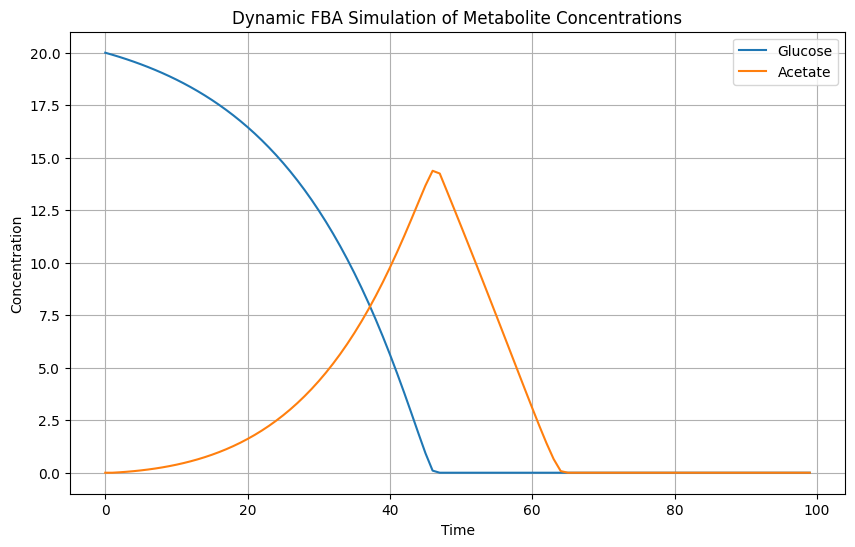

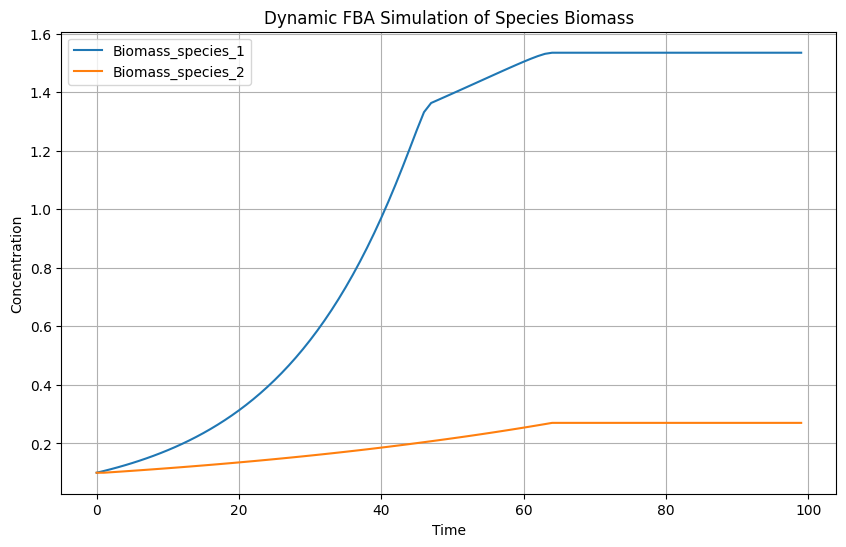

In [70]:
# plot metabolites
metabolite_results = {key: sim_results[key] for key in sim_results if key in ['glucose', 'acetate']}
plot_dfba_results(time_points, metabolite_results, title='Dynamic FBA Simulation of Metabolite Concentrations')

# plot biomass
biomass_results = {key: sim_results[key] for key in sim_results if 'biomass' in key}
plot_dfba_results(time_points, biomass_results, title='Dynamic FBA Simulation of Species Biomass')